Augment the literature data

In [6]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [46]:
# Visualize ptl1
data1 = data[data['ptl_idx']==1]
# X = np.array([data1['dt1'], data1['dw_mean']]).reshape((-1,2))
X = np.array(data1['dt1']).reshape(-1,1)
y = np.array(data1['dw_mean']).reshape(-1,1)

In [40]:
X.shape

(45, 1)

[-110, 100, -50, 120]

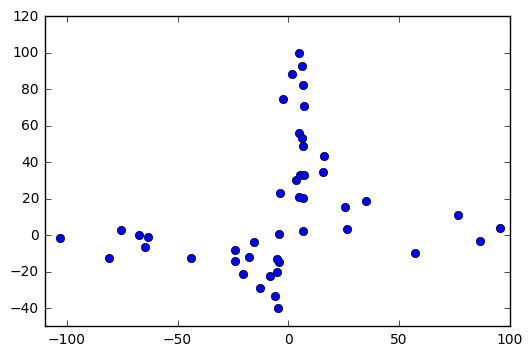

In [16]:
plt.plot(data1['dt1'], data1['dw_mean'], 'o')
plt.axis([-110, 100, -50, 120])

In [123]:
list(data.columns)

['ptl_idx',
 'pre_spk_num',
 'pre_spk_freq',
 'post_spk_num',
 'post_spk_freq',
 'ptl_occ',
 'ptl_freq',
 'dt1',
 'dt2',
 'dt3',
 'dw_mean',
 'dw_ste',
 'train_len']

In [128]:
# Generate dt1
# Insert values for STDP
dt = np.arange(-100,100,2)
data1_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try1 = data1.iloc[0]
    new_try1['dt1'] = dt[i]
    data1_gen = data1_gen.append(new_try1, ignore_index=True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-110, 100, -50, 120]

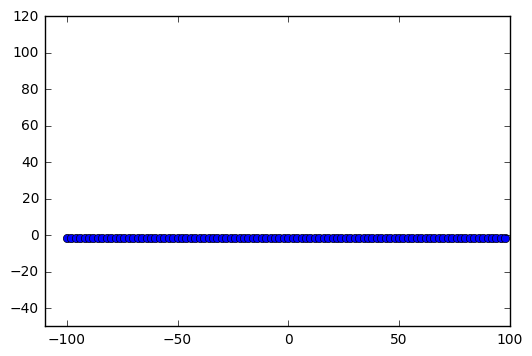

In [130]:
plt.plot(data1_gen['dt1'], data1_gen['dw_mean'], 'o')
plt.axis([-110, 100, -50, 120])

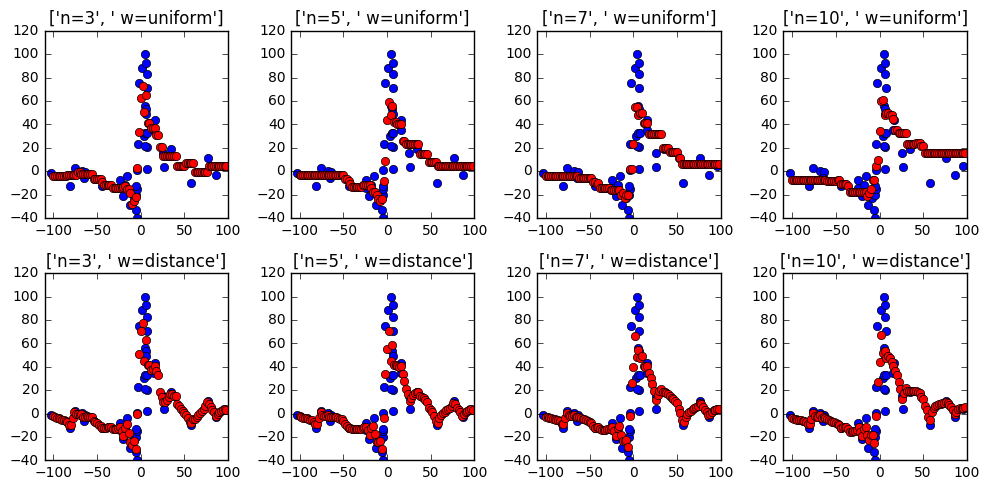

In [131]:
# Use K nearest neigbors to estimate the mean value of a given dt1
from sklearn.neighbors import KNeighborsRegressor

# Search through the parameter for the one gives the minimum reconstruction error
n_neighbors = [3,5,7,10]
weights = ['uniform', 'distance']

figure, ax = plt.subplots(2,4)
figure.set_figheight(5)
figure.set_figwidth(10)

for j in range(len(weights)):
    for i in range(len(n_neighbors)):
        
        Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors[i], weights=weights[j])
        Kn_reg.fit(X,y)
        y_pred = Kn_reg.predict(np.array(data1_gen['dt1']).reshape(-1,1))
        
        # Calculate mean squared error
        
        ax[j,i].plot(data1['dt1'], data1['dw_mean'], 'o')
        ax[j,i].plot(data1_gen['dt1'], y_pred, 'ro')
        ax[j,i].set_xlim([-110,100])
        ax[j,i].set_title(['n=%d'%(n_neighbors[i]), ' w=%s'%(weights[j])])
plt.tight_layout()

1.0 1.0000000000000002


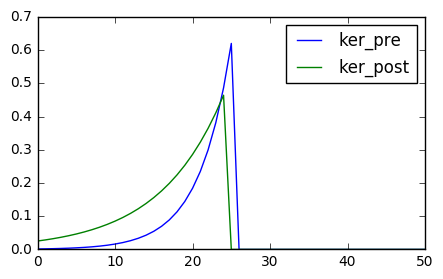

In [132]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen()
ker_test.trip_model_ker(para)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))

In [135]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data1_gen, ptl_list=ptl_list, targets=y_pred, spk_len=spk_len, kernel=ker_test, aug_times=[10])

In [137]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])